In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.optimize import brentq
from scipy.stats import norm

from futu import *
import time

from options import *
import pandas as pd

In [2]:
# open quote conn
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)
quote_ctx

2023-09-13 12:35:00,686 | 7780 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=1, host=127.0.0.1, port=11111, user_id=24402709


In [3]:
# open trade conn

# trd_ctx = OpenSecTradeContext(filter_trdmarket=TrdMarket.US, host='127.0.0.1', port=11111, security_firm=SecurityFirm.FUTUSECURITIES)
trd_ctx = OpenSecTradeContext(filter_trdmarket=TrdMarket.HK, host='127.0.0.1', port=11111, security_firm=SecurityFirm.FUTUSECURITIES)

2023-09-13 12:35:00,719 | 7780 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=2, host=127.0.0.1, port=11111, user_id=24402709


In [60]:
# end conn
quote_ctx.close()
trd_ctx.close()

2023-07-04 12:19:10,523 | 18556 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=1
2023-07-04 12:19:10,535 | 18556 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=2


In [145]:
# check subs
quote_ctx.query_subscription()

(0, {'total_used': 0, 'remain': 1000, 'own_used': 0, 'sub_list': {}})

# Account Info

In [60]:
Net_Asset = 366864.09
ret, acc_info = trd_ctx.accinfo_query()
print("Maintenance Ratio:", acc_info['maintenance_margin'][0]/Net_Asset)
maint_bal = Net_Asset-acc_info['maintenance_margin'][0]
print("Maintenance Balance:", maint_bal)
print("Net Asset after Realized:", Net_Asset-acc_info['short_mv'][0])
acc_info

Maintenance Ratio: 0.41483959359445616
Maintenance Balance: 214674.34000000003
Net Asset after Realized: 420994.09


,power,max_power_short,net_cash_power,total_assets,cash,market_val,long_mv,short_mv,pending_asset,interest_charged_amount,...,jp_cash,jp_avl_withdrawal_cash,sg_cash,sg_avl_withdrawal_cash,is_pdt,pdt_seq,beginning_dtbp,remaining_dtbp,dt_call_amount,dt_status
0,353283.90599,294403.25499,287662.722,14333.26,64023.26,-49690.0,4440.0,-54130.0,0.0,0.0,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [49]:
ret, positions = trd_ctx.position_list_query()
positions

,code,stock_name,qty,can_sell_qty,cost_price,cost_price_valid,market_val,nominal_price,pl_ratio,pl_ratio_valid,...,today_buy_qty,today_buy_val,today_pl_val,today_trd_val,today_sell_qty,today_sell_val,position_side,unrealized_pl,realized_pl,currency
0,HK.ALB231030P85000,阿里 231030 85.00 沽,-25.0,-25.0,3.692,True,-46250.0,3.70,-0.22,True,...,0.0,0.0,-3000.0,-3000.0,0.0,0.0,SHORT,N/A,N/A,HKD
1,HK.TCH231030P300000,腾讯 231030 300.00 沽,-20.0,-20.0,4.550,True,-7880.0,3.94,13.41,True,...,0.0,0.0,280.0,280.0,0.0,0.0,SHORT,N/A,N/A,HKD
2,HK.00020,商汤-W,3000.0,3000.0,1.690,True,4440.0,1.48,-12.43,True,...,0.0,0.0,-60.0,-60.0,0.0,0.0,LONG,N/A,N/A,HKD


# Position Analysis

In [77]:
joined['option_contract_multiplier']

0    500.0
Name: option_contract_multiplier, dtype: float64

In [95]:
def find_maintenance_critical_price(positions,maint_bal,current_stock_price):
    funcs = []
    for idx,row in positions.iterrows():
        p = lambda s:black_scholes(s, row['option_strike_price'],
                      row['option_type'],row['option_expiry_date_distance'],
                      row['option_implied_volatility'],risk_free_return=0.05)
        qty = row['qty']
        nom = row['nominal_price']
        mul = row['option_contract_multiplier']
        fn = lambda s: (nom-p(s))*qty*mul
        funcs += [fn]

    F = lambda p: maint_bal - sum([f(p) for f in funcs])

    r = brentq(F,1,current_stock_price*2)
    return r

In [97]:
stock_code = "HK.09988"
option_codes = ["HK.ALB231030P85000"]
current_stock_price = get_price(quote_ctx,stock_code)
sel_positions = positions[positions['code'].isin(option_codes)]
ret, option_info = quote_ctx.get_market_snapshot(option_codes)
joined = sel_positions.join(option_info.set_index('code'), on='code', how='left')
cp = find_maintenance_critical_price(joined,maint_bal,current_stock_price)
print("critical price:",cp)

critical price: 63.61323854860007


In [82]:
joined

,code,stock_name,qty,can_sell_qty,cost_price,cost_price_valid,market_val,nominal_price,pl_ratio,pl_ratio_valid,...,pre_turnover,pre_change_val,pre_change_rate,pre_amplitude,after_price,after_high_price,after_low_price,after_change_val,after_change_rate,after_amplitude
0,HK.ALB231030P85000,阿里 231030 85.00 沽,-25.0,-25.0,3.692,True,-46250.0,3.7,-0.22,True,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


# get current position & available options

In [34]:
stock_code = "HK.09988"
ret, positions = trd_ctx.position_list_query()
positions = positions[positions['code'].str.contains("HK.ALB230728")]

NameError: name 'current_stock_price' is not defined

In [5]:
options = get_options(quote_ctx, stock_code, date="2023-07-28")
current_stock_price = get_price(quote_ctx,stock_code)

val = options[['strike_price','option_type','option_expiry_date_distance','option_implied_volatility']].values.tolist()

theoretical_price = []
for k,typ,t,vol in val:
    theoretical_price.append(black_scholes(current_stock_price,k,typ,t,vol))
options['theoretical_price'] = theoretical_price
options

,code,strike_price,option_type,last_price,option_implied_volatility,option_expiry_date_distance,option_contract_size,option_delta,option_gamma,option_vega,option_theta,option_rho,theoretical_price
0,HK.ALB230728P50000,50.0,PUT,0.01,78.213,21,500.0,-0.002041,0.000407,0.001311,-0.002238,-0.000081,0.01
1,HK.ALB230728P52500,52.5,PUT,0.01,71.417,21,500.0,-0.002229,0.000483,0.001420,-0.002217,-0.000089,0.01
2,HK.ALB230728P55000,55.0,PUT,0.01,64.912,21,500.0,-0.002444,0.000577,0.001544,-0.002193,-0.000099,0.01
3,HK.ALB230728P57500,57.5,PUT,0.01,58.668,21,500.0,-0.002694,0.000697,0.001686,-0.002167,-0.000110,0.01
4,HK.ALB230728P60000,60.0,PUT,0.01,52.656,21,500.0,-0.002987,0.000853,0.001851,-0.002139,-0.000123,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,HK.ALB230728C180000,180.0,CALL,0.01,103.624,21,500.0,0.001752,0.000267,0.001141,-0.002537,0.000062,0.01
70,HK.ALB230728C182500,182.5,CALL,0.01,105.289,21,500.0,0.001728,0.000260,0.001127,-0.002544,0.000061,0.01
71,HK.ALB230728C185000,185.0,CALL,0.01,106.927,21,500.0,0.001705,0.000253,0.001113,-0.002551,0.000060,0.01
72,HK.ALB230728C187500,187.5,CALL,0.01,108.540,21,500.0,0.001683,0.000246,0.001100,-0.002558,0.000059,0.01


delta = 4430.604982206406
theta = -1955.0
gamma = -12249.366424212236
Ytm @ 84.3: 60456.0
Realized @ 84.3: 23376.0
Unrealized @ 84.3: 37080.0
target r: 14%
target Ytm: 73656.16
unreazlied r: 10.66%


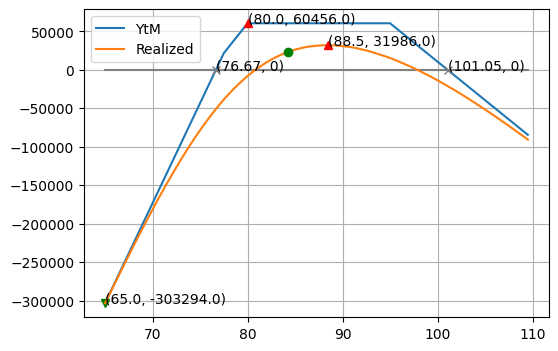

In [6]:
joined = positions.join(options.set_index('code'), on='code', how='left')
position_objs = OptionPosition.from_df(joined)
    
analysis=position_analysis(position_objs,current_stock_price)

t=6
npv=44489
fv=100000
usd_hkd=7.82


unrealized_r = analysis['unrealized']/usd_hkd/npv*100
target_r = HPR(npv,fv,t)
target_ytm = npv*target_r/100*usd_hkd+analysis['realized']

print(f"delta = {analysis['delta']}")
print(f"theta = {analysis['theta']}")
print(f"gamma = {analysis['gamma']}")

print(f"Ytm @ {current_stock_price}: {analysis['ytm']}")
print(f"Realized @ {current_stock_price}: {analysis['realized']}")
print(f"Unrealized @ {current_stock_price}: {analysis['unrealized']}")
print(f"target r: {round(target_r)}%")
print(f"target Ytm: {round(target_ytm,2)}")
print(f"unreazlied r: {round(unrealized_r,2)}%")

# hedge analysis

In [63]:
def getHedgeInfo(code, use_current_price=True, price=0, qty=0, infolist=[],hedgelist=[]):
    opt = options.loc[options['code'] == code].iloc[0]
    if use_current_price:
        opt['cost_price'] = opt['last_price']
    else:
        opt['cost_price'] = price
    
    ret, acctradinginfo = trd_ctx.acctradinginfo_query(order_type=OrderType.NORMAL, code=code, price=opt['cost_price'])
    opt['qty'] = qty
    
    hedge = OptionPosition.from_series(opt)
    acctradinginfo.insert(0, 'code', code)
    hedgelist.append(hedge)
    infolist.append(acctradinginfo)
    
    return hedge, acctradinginfo

In [64]:
hedges,infos=[],[]
getHedgeInfo("HK.ALB230728P80000",use_current_price=True,price=0,qty=-10,infolist=infos,hedgelist=hedges)
getHedgeInfo("HK.ALB230728P77500",use_current_price=True,price=0,qty=-2,infolist=infos,hedgelist=hedges)
getHedgeInfo("HK.ALB230728C95000",use_current_price=True,price=0,qty=10,infolist=infos,hedgelist=hedges)
pd.concat(infos,axis=0)

,code,max_cash_buy,max_cash_and_margin_buy,max_position_sell,max_sell_short,max_buy_back,long_required_im,short_required_im
0,HK.ALB230728P80000,180.0,180.0,0.0,30.0,31.0,-4195.02,4195.03
0,HK.ALB230728P77500,340.0,340.0,0.0,36.0,21.0,-3441.97,3441.98
0,HK.ALB230728C95000,360.0,360.0,0.0,46.0,20.0,0.00,0.00


hedges: [PUT80.0/-10@1.4, PUT77.5/-2@0.74, CALL95.0/10@0.7]
5591.016548463357 6843.971631205674
delta = 6223.404255319153
theta = -1940.0000000000036
gamma = -12882.204673362063
Ytm @ 84.6: 64696.0
Realized @ 84.6: 26531.0
Unrealized @ 84.6: 38165.0
target r: 14%
target Ytm: 76811.16
unreazlied r: 10.97%


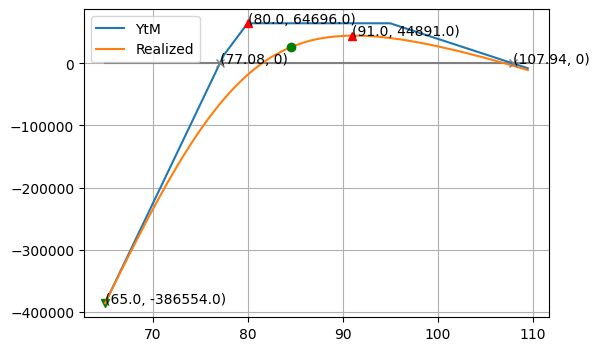

In [65]:
print(f"hedges: {hedges}")
analysis=position_analysis(position_objs+hedges,current_stock_price)

unrealized_r = analysis['unrealized']/usd_hkd/npv*100
target_r = HPR(npv,fv,t)
target_ytm = npv*target_r/100*usd_hkd+analysis['realized']

print(f"delta = {analysis['delta']}")
print(f"theta = {analysis['theta']}")
print(f"gamma = {analysis['gamma']}")

print(f"Ytm @ {current_stock_price}: {analysis['ytm']}")
print(f"Realized @ {current_stock_price}: {analysis['realized']}")
print(f"Unrealized @ {current_stock_price}: {analysis['unrealized']}")
print(f"target r: {round(target_r)}%")
print(f"target Ytm: {round(target_ytm,2)}")
print(f"unreazlied r: {round(unrealized_r,2)}%")

# hedge optimization

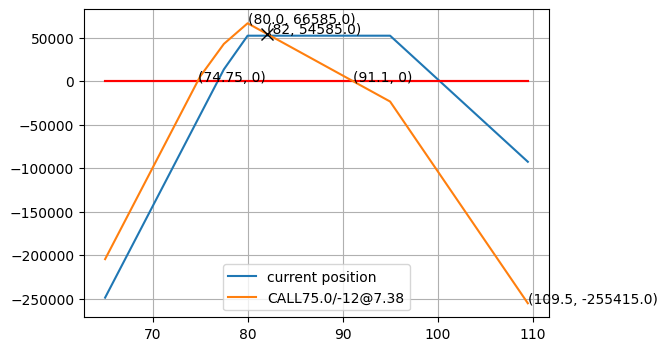

In [468]:
# filtered = options[options['option_type']=="CALL"]
# filtered = filtered[filtered['strike_price']<95]
# filtered = filtered[filtered['strike_price']>=65]

# hedges = queue_possible_hedge(filtered, direction="SHORT", use_current_price=True)
# minmod,minroots = rank_by_min_root(position_objs, hedges)

xstart=65
xend=110
intv=0.5
fig, ax = plt.subplots(figsize=(6,4))
ax.grid()
draw_curve(position_objs,xstart,xend,intv,show_text=False,fig=fig,label="current position")
for mod in minmod[:1]:
    draw_curve(position_objs+[mod],xstart,xend,intv,show_text=True,fig=fig,label=mod,poi=[82])

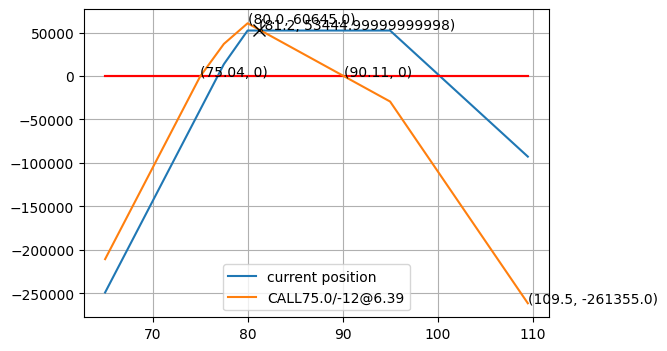

In [469]:
filtered = options[options['option_type']=="CALL"]
filtered = filtered[filtered['strike_price']<90]
filtered = filtered[filtered['strike_price']>=65]

hedges = queue_possible_hedge(filtered, direction="SHORT", use_current_price=False, stock_price=80, expiry=25)
minmod,minroots = rank_by_min_root(position_objs, hedges)

xstart=65
xend=110
intv=0.5
fig, ax = plt.subplots(figsize=(6,4))
ax.grid()
draw_curve(position_objs,xstart,xend,intv,show_text=False,fig=fig,label="current position")
for mod in minmod[:1]:
    draw_curve(position_objs+[mod],xstart,xend,intv,show_text=True,fig=fig,label=mod,poi=[81.2])

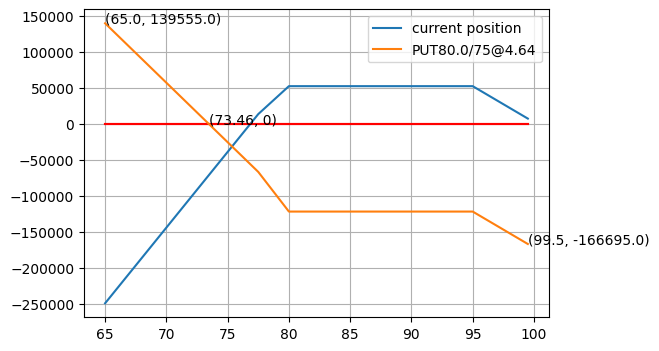

In [473]:
# filtered = options[options['option_type']=="PUT"]
# filtered = filtered[filtered['strike_price']<90]
# filtered = filtered[filtered['strike_price']>=55]

# hedges = queue_possible_hedge(filtered, direction="LONG", use_current_price=False, stock_price=77, expiry=25)
# aug_hedges = augment_option(hedges,num_steps=10)

mods, intg = rank_by_integral(position_objs, aug_hedges, xstart=70, xend=75, intv=0.125)

xstart=65
xend=100
intv=0.5
fig, ax = plt.subplots(figsize=(6,4))
ax.grid()
draw_curve(position_objs,xstart,xend,intv,show_text=False,fig=fig,label="current position")
for mod in mods[-1:]:
    draw_curve(position_objs+[mod],xstart,xend,intv,show_text=True,fig=fig,label=mod,poi=[])

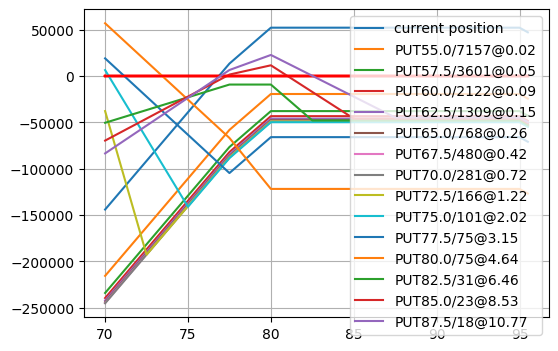

In [410]:
xstart=70
xend=96
intv=0.5

fig, ax = plt.subplots(figsize=(6,4))
draw_curve(position_objs,xstart,xend,intv,show_text=False,fig=fig,label="current position")
for mod in hedges:
    draw_curve(position_objs+[mod],xstart,xend,intv,show_text=False,fig=fig,label=mod)